<a href="https://colab.research.google.com/github/cderamond/mba_UTFSM_finanzas/blob/caso_final/casoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 2 (50 puntos)

Descargar desde https://finance.yahoo.com/ los precios históricos mensuales de
10 acciones (marzo 2011 a marzo 2022). Las acciones deben ser (transarse) en
Estados Unidos y como máximo 3 acciones deben corresponder al mismo sector
industrial. A partir de los datos mensuales, las estadísticas de cada acción y la correlación entre cada par de ellas:



### Preparación y cálculos

In [1]:
!pip install yfinance --upgrade --no-cache-dir
!pip install PyPortfolioOpt

     |████████████████████████████████| 6.4 MB 6.3 MB/s 
     |████████████████████████████████| 63 kB 30.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 61 kB 1.8 MB/s 
     |████████████████████████████████| 2.8 MB 8.0 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.

In [2]:
# setting environment
import numpy as np
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import seaborn as sns

In [3]:
# bajar stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'KO', 'AMZN', 'GM', 'F', 'BRK-B', 'DIS']
start_date = '2011-03-01'
end_date = '2022-03-30'

# bajamos la data de todas las acciones
data = yf.download(tickers, start_date, end_date, group_by='ticker')
# ahora las del SP500, VOO ETF como benchmark
sp= yf.download('VOO', start_date, end_date, group_by='ticker')

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# filtrar los datos
dataadj = data.loc[:,(slice(None),'Adj Close')]
# revisar la estructura de datos
dataadj.dtypes

GOOGL  Adj Close    float64
KO     Adj Close    float64
AMZN   Adj Close    float64
F      Adj Close    float64
AAPL   Adj Close    float64
MSFT   Adj Close    float64
TSLA   Adj Close    float64
DIS    Adj Close    float64
BRK-B  Adj Close    float64
GM     Adj Close    float64
dtype: object

In [5]:
# cambio porcentual en log
dataadj = (dataadj.pct_change().apply(lambda x: np.log(1+x))
            .dropna()
            )
dataadj

,GOOGL,KO,AMZN,F,AAPL,MSFT,TSLA,DIS,BRK-B,GM
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
Date,,,,,,,,,,
2011-03-02,0.000050,-0.007423,0.015112,0.000000,0.008012,-0.003063,0.003336,0.006954,-0.002702,-0.002127
2011-03-03,0.014492,0.017539,0.004466,0.006798,0.020909,0.004591,0.014056,0.017858,0.019567,0.004552
2011-03-04,-0.014775,-0.005505,-0.006503,-0.023304,0.001223,-0.009588,0.023931,-0.011870,-0.013937,-0.019566
2011-03-07,-0.015030,0.000153,-0.015202,-0.028845,-0.012973,-0.008903,-0.000401,-0.012245,-0.005395,-0.021533
2011-03-08,0.001098,0.006419,-0.013037,0.032306,0.001125,0.007360,-0.011290,0.004175,0.015287,0.031670
...,...,...,...,...,...,...,...,...,...,...
2022-03-23,-0.011451,-0.006601,-0.009022,-0.024283,0.008200,-0.015144,0.005148,-0.017786,-0.005071,-0.017660
2022-03-24,0.023560,0.009557,0.001477,0.008953,0.022425,0.015276,0.014714,0.009545,0.012020,0.012936


### Representaciones gráficas

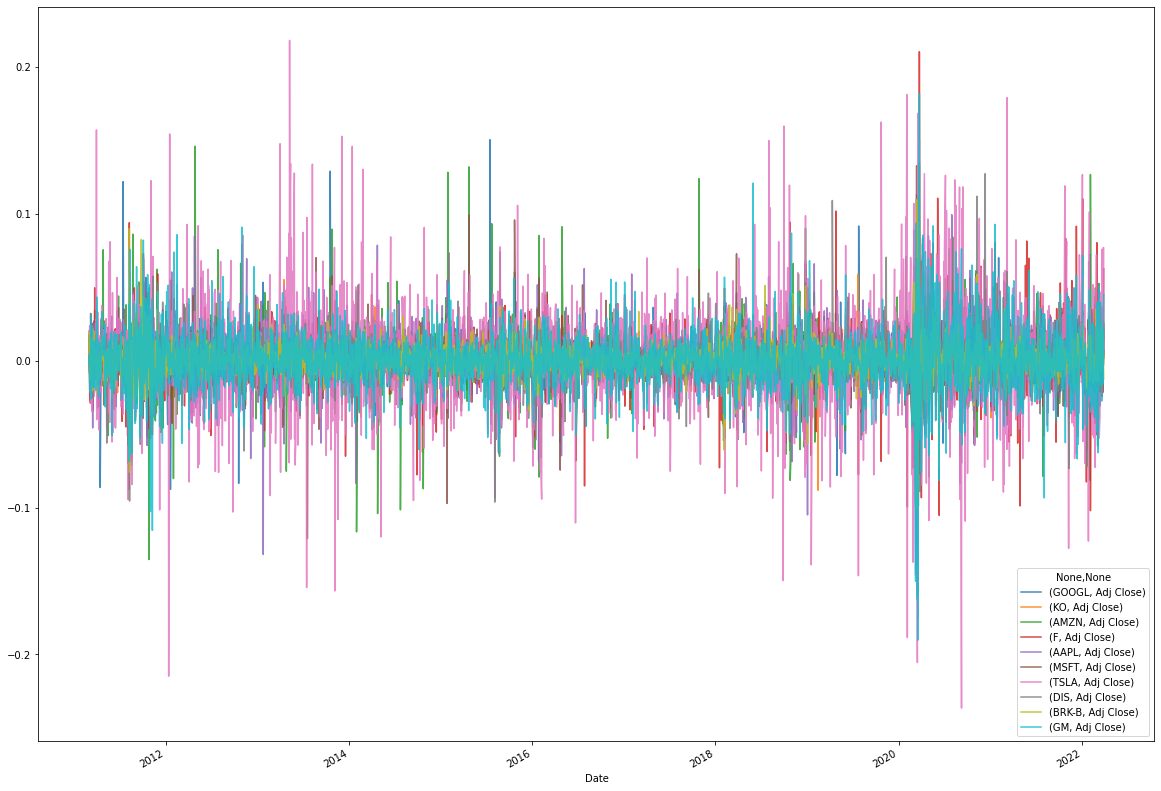

In [6]:
# gráfica de rentabilidades
dataadj.plot(figsize=(20,15), alpha=.85)

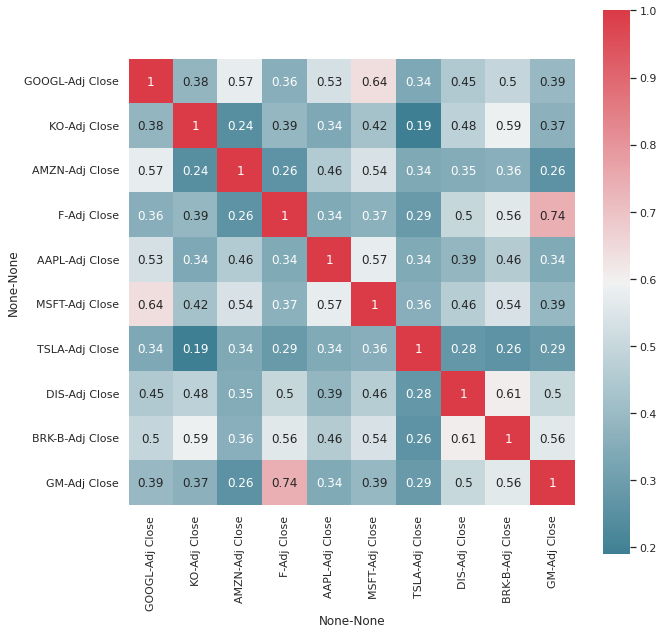

In [7]:
# representación matriz de correlaciones
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(dataadj.corr(), annot=True, 
            mask=np.zeros_like(dataadj.corr(), dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True,
            )

A destacar:
* Alta correlación entre Ford [F](https://g.co/finance/F:NYSE)
y [GM](https://www.google.com/finance/quote/gm:nyse)
, sin embargo, vemos que Tesla [$TSLA](https://www.google.com/finance/quote/tsla:nasdaq) es prácticamente no relacionada.
* [MSFT](https://www.google.com/finance/quote/MSFT:NASDAQ) y  [GOOGL](https://www.google.com/finance/quote/GOOGL:NASDAQ) también presentan una relación destacable.

### Análisis varianza

In [8]:
dataadj.describe()

,GOOGL,KO,AMZN,F,AAPL,MSFT,TSLA,DIS,BRK-B,GM
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
count,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000
mean,0.000806,0.000358,0.001074,0.000198,0.001011,0.000977,0.001949,0.000475,0.000512,0.000214
std,0.016290,0.011139,0.019769,0.020320,0.017841,0.016120,0.034911,0.015884,0.012373,0.021437
min,-0.123685,-0.101728,-0.135325,-0.116674,-0.137708,-0.159453,-0.236518,-0.139085,-0.100838,-0.190227
25%,-0.006589,-0.004515,-0.008389,-0.009473,-0.007335,-0.006582,-0.014781,-0.006470,-0.005465,-0.010191
50%,0.000931,0.000487,0.001101,0.000000,0.000888,0.000695,0.001266,0.000610,0.000481,0.000282
75%,0.008910,0.005891,0.011220,0.009895,0.010399,0.009007,0.018901,0.007776,0.006536,0.010573
max,0.150645,0.062783,0.146225,0.210596,0.113157,0.132929,0.218292,0.134639,0.109840,0.181848


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41969681d0>,
      dtype=object)

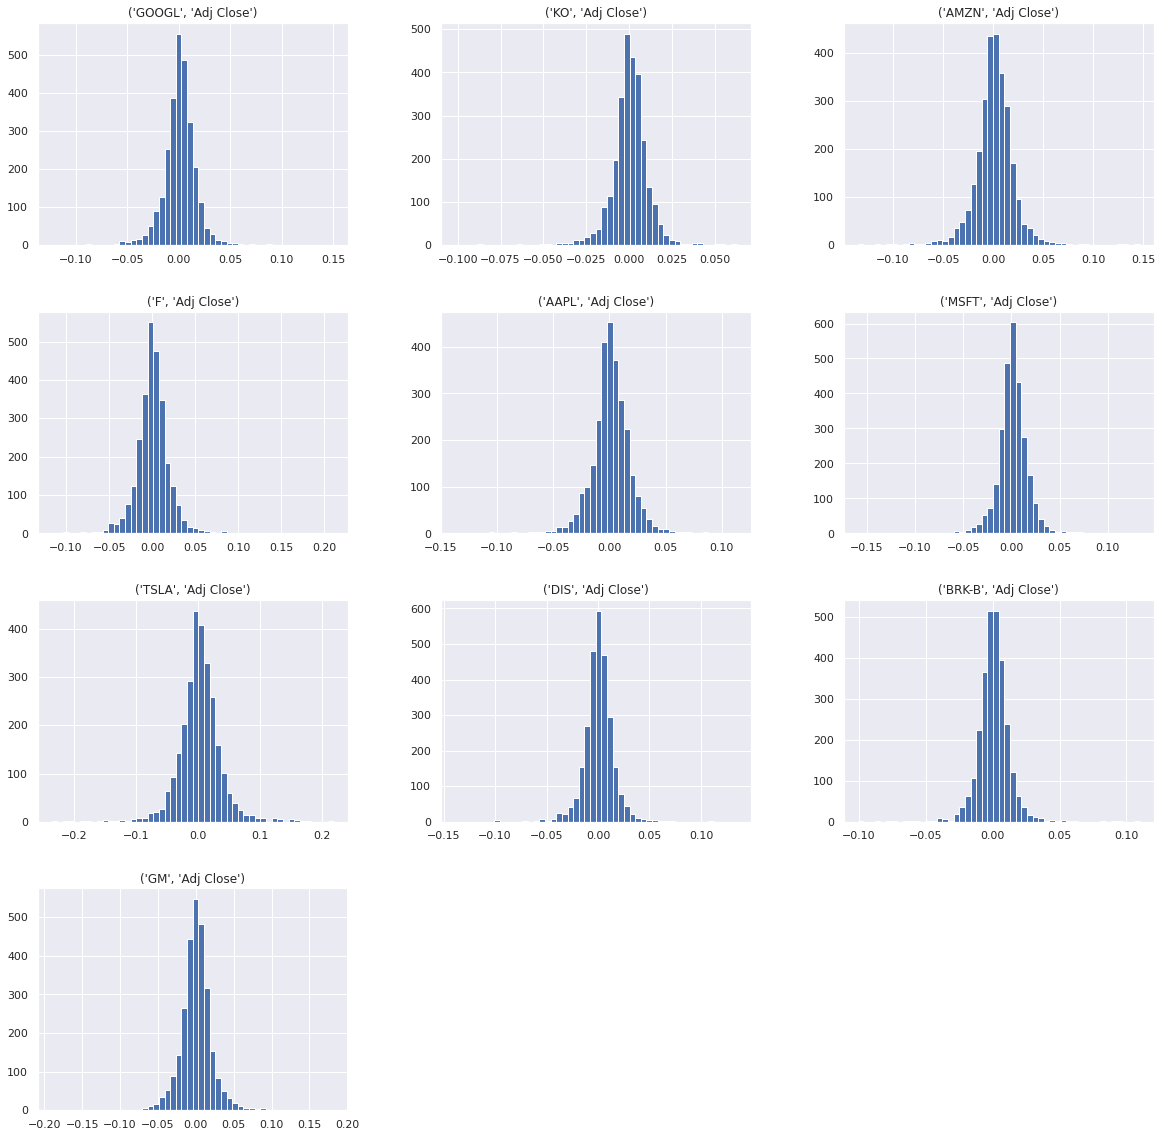

In [9]:
dataadj.hist(bins=50, figsize=(20, 20))

## A) Describa los principales negocios, riesgos e industria a la que pertenece.



Industria seleccionada: **Automotriz** 
*   Tesla $TSLA

*   General Motors $GM

*   Ford $F

### Estadísticas

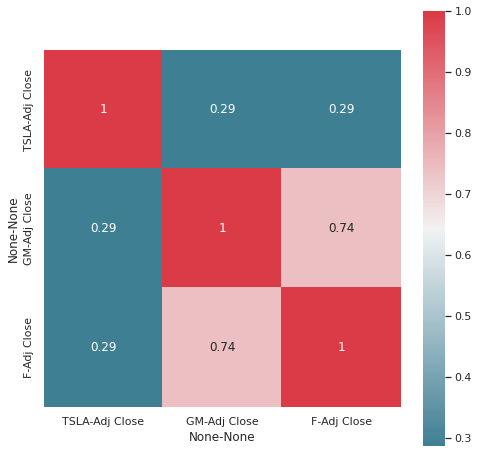

In [10]:
auto = dataadj.loc[:, (['TSLA', 'GM', 'F'], slice(None))]
# Matriz de correlaciones
sns.set(rc={"figure.figsize":(8, 8)})
sns.heatmap(auto.corr(), annot=True, 
            mask=np.zeros_like(auto.corr(), dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True,
            )

In [11]:
# Matriz Covarianza
dataadj.cov()

,,GOOGL,KO,AMZN,F,AAPL,MSFT,TSLA,DIS,BRK-B,GM
,,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
GOOGL,Adj Close,0.000265,0.000069,0.000185,0.000118,0.000155,0.000168,0.000191,0.000116,0.000100,0.000137
KO,Adj Close,0.000069,0.000124,0.000054,0.000088,0.000067,0.000076,0.000074,0.000085,0.000081,0.000088
AMZN,Adj Close,0.000185,0.000054,0.000391,0.000105,0.000161,0.000172,0.000234,0.000110,0.000088,0.000110
F,Adj Close,0.000118,0.000088,0.000105,0.000413,0.000125,0.000120,0.000204,0.000161,0.000141,0.000323
AAPL,Adj Close,0.000155,0.000067,0.000161,0.000125,0.000318,0.000165,0.000213,0.000109,0.000101,0.000131
MSFT,Adj Close,0.000168,0.000076,0.000172,0.000120,0.000165,0.000260,0.000201,0.000119,0.000108,0.000136
TSLA,Adj Close,0.000191,0.000074,0.000234,0.000204,0.000213,0.000201,0.001219,0.000153,0.000112,0.000215
DIS,Adj Close,0.000116,0.000085,0.000110,0.000161,0.000109,0.000119,0.000153,0.000252,0.000119,0.000170
BRK-B,Adj Close,0.000100,0.000081,0.000088,0.000141,0.000101,0.000108,0.000112,0.000119,0.000153,0.000149


### Volatilidad


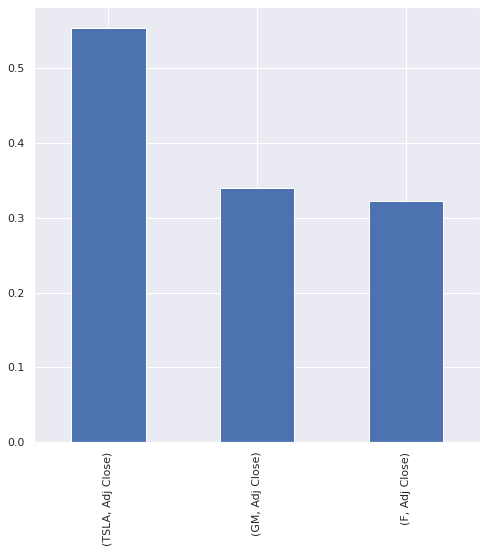

In [12]:
# Volatilidad anualizada a 252 días de trading
auto.std().apply(lambda x: x*np.sqrt(252)).plot(kind='bar')

### Rentabilidad esperada

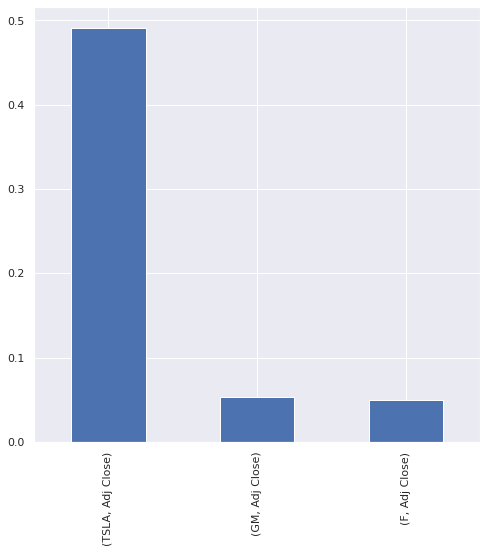

In [13]:
auto.mean().apply(lambda x: x*252).plot(kind='bar')

## B) Determine la rentabilidad y riesgo del portafolio invirtiendo 10% en cada acción.

### Preparación del portfolio

In [14]:
# librerias portfolio
from matplotlib.ticker import FuncFormatter
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
#from pypfopt.plotting import Plotting
from matplotlib.ticker import FuncFormatter

In [15]:
# vector inicial
w = [.1] *10

# Annualized Return
price=data.loc[:,(slice(None),'Adj Close')]
# Retornos anualizados a 252 días año
mu = expected_returns.mean_historical_return(price, compounding=False, log_returns=True)
S = risk_models.CovarianceShrinkage(price, log_returns=True).ledoit_wolf()
# Los retornos esperados
mu

GOOGL  Adj Close    0.203214
KO     Adj Close    0.090282
AMZN   Adj Close    0.270613
F      Adj Close    0.049923
AAPL   Adj Close    0.254672
MSFT   Adj Close    0.246081
TSLA   Adj Close    0.491220
DIS    Adj Close    0.119696
BRK-B  Adj Close    0.128925
GM     Adj Close    0.053933
dtype: float64

### Respuesta

**El retorno del portfalio con cada acción al 10%:**

In [16]:
print("Retorno esperado, Er= ", (mu*w).sum())

Retorno esperado, Er=  0.19085583427526107


**Riesgo y varianza del portafolio:**

In [17]:
print("Varianza de portafolio: ", S.mul(w, axis=0).mul(w, axis=1).sum().sum())
print("Std dev de portafolio: ", np.sqrt(S.mul(w, axis=0).mul(w, axis=1).sum().sum()))
Sb=S.mul(w, axis=0).mul(w, axis=1).sum().sum()

Varianza de portafolio:  0.04019539981918496
Std dev de portafolio:  0.20048790442115197


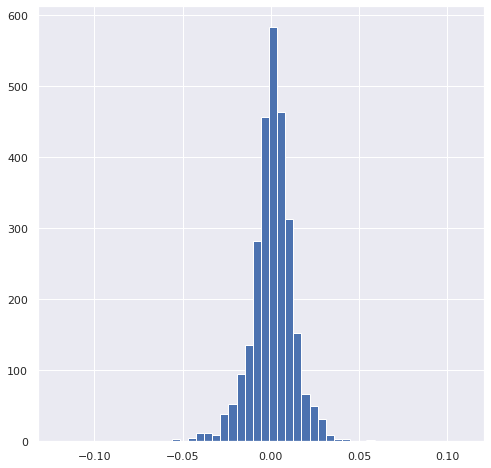

In [18]:
Erb=np.sum(dataadj*w, axis=1)
Erb.hist(bins=50)

## C) Determine el portafolio de mínima varianza.

Debemos preparar la data para simular. Por simplicidad, para el montecarlo tomaremos el libre de riesgo como 0.

### Montecarlo

In [19]:
# Monte Carlo Simulation
n = 15000

weights = np.zeros((n, 10))
exp_rtns = np.zeros(n)
exp_vols = np.zeros(n)
sharpe_ratios = np.zeros(n)
 
for i in range(n):
    weight = np.random.random(10)
    weight /= weight.sum()
    weights[i] = weight
     
    exp_rtns[i] = np.sum(dataadj.mean()*weight)*252
    exp_vols[i] = np.sqrt(np.dot(weight.T, np.dot(dataadj.cov()*252, weight)))
    sharpe_ratios[i] = exp_rtns[i] / exp_vols[i]

En base a nuestra simulación de `n` iteraciones


### Min. Varianza

Todo basado en las simulaciones Montecarlo

In [20]:
print("Min volatilidad: ", exp_vols.min())
print("Retorno esperado: ", exp_rtns[exp_vols.argmin()])
print("Ratio Sharpe", sharpe_ratios[exp_vols.argmin()])
print("Distribución: ", weights[exp_vols.argmin()])

Min volatilidad:  0.17381464271799452
Retorno esperado:  0.15068250356662252
Ratio Sharpe 0.8669148997481028
Distribución:  [0.12358363 0.23084008 0.04552908 0.0431311  0.07188989 0.06475403
 0.01846797 0.14649602 0.20848162 0.04682659]


## D) Determine el portafolio óptimo Sharpe (determine Rf según el mercado seleccionado y justifique el valor calculado).

### Determinando la tasa libre de riesgo

La T-bill está a hoy en 2.54% nominal para 10 años, que es enuestro periodo de evaluación.
Dado que buscamos la tasa efectiva diaria
\begin{align}
       (1+ r)^{365} = (1+2.54\%)^1
    \end{align}
Aunque las funciones de todas maneras funcionan con la tasa nominal, razón por la que anualizamos todos los flujos.

In [22]:
#tasa nominal
r=.0254

### Cálculo del máximo de Sharpe, todas las acciones

In [23]:
# importar la librería de FE
from pypfopt.efficient_frontier import EfficientFrontier
# Definimos la FE maximizando el Sharpe
# r que es nuestra tasa libre, ya la definimos en la sección anterior.
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=r) 

cleaned_weights = ef.clean_weights()

Los pesos de la frontera eficiente:

In [24]:
cleaned_weights

OrderedDict([(('GOOGL', 'Adj Close'), 0.0),
             (('KO', 'Adj Close'), 0.0),
             (('AMZN', 'Adj Close'), 0.20737),
             (('F', 'Adj Close'), 0.0),
             (('AAPL', 'Adj Close'), 0.25113),
             (('MSFT', 'Adj Close'), 0.32214),
             (('TSLA', 'Adj Close'), 0.21936),
             (('DIS', 'Adj Close'), 0.0),
             (('BRK-B', 'Adj Close'), 0.0),
             (('GM', 'Adj Close'), 0.0)])

**Los parámetros y resultados de la frontera eficiente:**

In [25]:
ef.portfolio_performance(verbose=True, risk_free_rate=r)

Expected annual return: 30.7%
Annual volatility: 25.6%
Sharpe Ratio: 1.10


(0.3070983737177387, 0.25620002809261916, 1.0995251476549472)

### Cálculo del máximo de Sharpe, sólo auto

Dado que no entendí claramente la instrucción, repetiremos el ejercicio pero ahora sólo en la industria automotriz basándonos en [Pregunta A](https://colab.research.google.com/github/cderamond/mba_UTFSM_finanzas/blob/caso_final/casoFinal.ipynb#scrollTo=A_Describa_los_principales_negocios_riesgos_e_industria_a_la_que_pertenece_).

In [28]:
# Annualized Return
price_auto=data.loc[:,(['TSLA', 'GM', 'F'],'Adj Close')]
# Retornos anualizados a 252 días año
mu_auto = expected_returns.mean_historical_return(price_auto, compounding=False, log_returns=True)
S_auto = risk_models.CovarianceShrinkage(price_auto, log_returns=True).ledoit_wolf()
# Los retornos esperados
print("retornos, sólo auto:", mu_auto)
# Definimos la FE maximizando el Sharpe
# r que es nuestra tasa libre, ya la definimos en la sección anterior.
ef_auto = EfficientFrontier(mu_auto, S_auto)
weights_auto = ef_auto.max_sharpe(risk_free_rate=r) 
cleaned_weights_auto = ef_auto.clean_weights()

retornos, sólo auto: TSLA  Adj Close    0.491220
GM    Adj Close    0.053933
F     Adj Close    0.049923
dtype: float64


Los pesos de la frontera eficiente:

In [29]:
cleaned_weights_auto

OrderedDict([(('TSLA', 'Adj Close'), 1.0),
             (('GM', 'Adj Close'), 0.0),
             (('F', 'Adj Close'), 0.0)])

**Los parámetros y resultados de la frontera eficiente:**

In [30]:
ef_auto.portfolio_performance(verbose=True, risk_free_rate=r)

Expected annual return: 49.1%
Annual volatility: 55.3%
Sharpe Ratio: 0.84


(0.49122033948860794, 0.5527139262646424, 0.842787411992168)

Nada sorprendente, en la frontera eficiente nuestro portfolio de automotriz, tendría sólo Tesla.


## E) Determine la frontera eficiente de riesgo retorno (10 puntos al menos) e identifique en el gráfico los resultados obtenidos de las letras B), C) y D). Comente.

### Gráfiquemos la frontera eficiente

**X marca el óptimo de Sharpe**
**◆ marca el mín de volatilidad**

Text(0, 0.5, 'Expected Return')

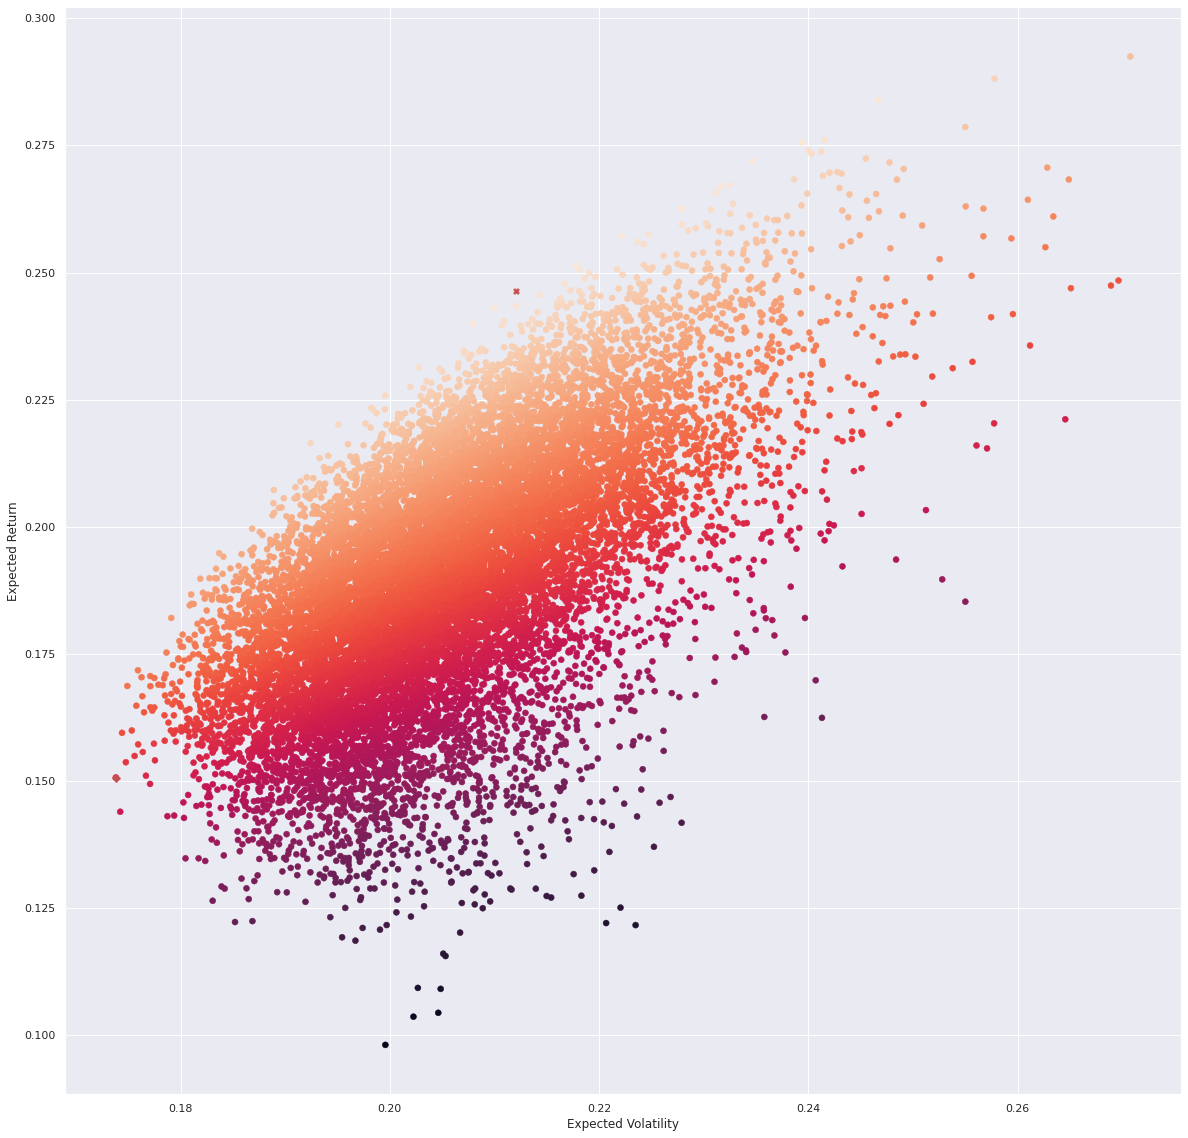

In [26]:
%matplotlib inline
 
fig, ax = plt.subplots(figsize=(20,20))
plt.style.use('ggplot')
ax.scatter(exp_vols, exp_rtns, c=sharpe_ratios)
ax.scatter(exp_vols[sharpe_ratios.argmax()], exp_rtns[sharpe_ratios.argmax()], c='r', marker='X')
ax.scatter(exp_vols.min(), exp_rtns[exp_vols.argmin()], c='r', marker='D')
ax.set_xlabel('Expected Volatility')
ax.set_ylabel('Expected Return')
